In [6]:
import numpy as np
import numpy.random as nr
from numpy import log, transpose, dot, identity, pi, e
from numpy.linalg import det

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import SGD

In [7]:
def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

def network_parameters(model):
    parameters=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            parameters.append(para[1].detach().numpy())
    return parameters

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size,bias=False) 
        self.output_layer = nn.Linear(hidden_size, output_size,bias=False)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.output_layer(x)
        return x

def MI_XT(W_bar, sigma_sq_MI,N_h):
    return log(det(dot(W_bar,transpose(W_bar))+sigma_sq_MI*identity(N_h)))-log(det(sigma_sq_MI*identity(N_h)))

def MI_TY(W_o, W_bar, N_o, N_h, sigma_sq_o, sigma_sq_MI):
    H_Y=N_o/2*log(2*pi*e)+log(det(dot(W_o,transpose(W_o))+sigma_sq_o*identity(N_o)))/2
    H_T=N_h/2*log(2*pi*e)+log(det(dot(W_bar,transpose(W_bar))+sigma_sq_MI*identity(N_h)))/2
    mat=np.zeros((N_o+N_h,N_o+N_h))
    mat[0:N_h,0:N_h]=dot(W_bar,transpose(W_bar))+sigma_sq_MI*identity(N_h)
    mat[0:N_h,N_h:]=dot(W_bar,transpose(W_o))
    mat[N_h:,0:N_h]=dot(W_o,transpose(W_bar))
    mat[N_h:,N_h:]=dot(W_o,transpose(W_o))+sigma_sq_o*identity(N_o)
    H_YT=(N_o+N_h)/2*log(2*pi*e)+log(det(mat))/2
    return H_Y+H_T-H_YT

In [8]:
def Mutual_Information(sigma_0, sigma_W, sigma_MI, hidden_units, input_size, output_size,P,num_epochs,batch_size,lr):
    W_0=nr.normal(0,sigma_W,(1,input_size))
    
    X=np.array([nr.multivariate_normal(np.zeros(input_size),np.identity(input_size)/input_size) for n in range(P)])
    Y=np.array([np.dot(W_0,x)+nr.normal(0,sigma_0) for x in X])

    X=torch.from_numpy(X).float()
    Y=torch.from_numpy(Y).float()

    model = NeuralNet(input_size,hidden_units,output_size)

    opt = SGD(model.parameters(), lr=lr)
    lossFunc = nn.MSELoss()

    LOSSES=[]
    MI_XT_list=[]
    MI_TY_list=[]
    EPOCH_list=[]

    for n in range(num_epochs):
        for x,y in next_batch(X,Y,batch_size):
            outputs=model(x)
            loss=lossFunc(outputs,y)
            opt.zero_grad()
            loss.backward()
            opt.step()
        EPOCH_list.append(n)
        LOSSES.append(loss.item())

        WEIGHTS=network_parameters(model)

        MI_XT_list.append(MI_XT(WEIGHTS[0],
                                sigma_MI**2,
                                hidden_units))
        MI_TY_list.append(MI_TY(W_0,
                                WEIGHTS[0],
                                input_size,
                                hidden_units,
                                sigma_0**2,
                                sigma_MI**2))
        if (n+1)%100==0:
            print('Epoch {}: Loss {}'.format(n+1,loss.item()))
    return LOSSES, MI_XT_list, MI_TY_list,EPOCH_list


In [9]:
SIGMA_0=1
SIGMA_W=1
SIGMA_MI=1
OUTPUT_SIZE=1
NUM_EPOCHS=2000

Epoch 100: Loss 0.16010259091854095
Epoch 200: Loss 0.08940813690423965
Epoch 300: Loss 0.06901852041482925
Epoch 400: Loss 0.057768650352954865
Epoch 500: Loss 0.052543312311172485
Epoch 600: Loss 0.05059107020497322
Epoch 700: Loss 0.050179921090602875
Epoch 800: Loss 0.05034027248620987
Epoch 900: Loss 0.05058576539158821
Epoch 1000: Loss 0.050705552101135254
Epoch 1100: Loss 0.05063189938664436
Epoch 1200: Loss 0.05036488175392151
Epoch 1300: Loss 0.04993147775530815
Epoch 1400: Loss 0.04936655983328819
Epoch 1500: Loss 0.04870390146970749
Epoch 1600: Loss 0.0479719340801239
Epoch 1700: Loss 0.04719331115484238
Epoch 1800: Loss 0.04638596624135971
Epoch 1900: Loss 0.04556260257959366
Epoch 2000: Loss 0.044733159244060516
Epoch 100: Loss 0.05863974615931511
Epoch 200: Loss 0.07123472541570663
Epoch 300: Loss 0.04851610213518143
Epoch 400: Loss 0.030415594577789307
Epoch 500: Loss 0.02128448896110058
Epoch 600: Loss 0.016673551872372627
Epoch 700: Loss 0.01417569350451231
Epoch 800: 

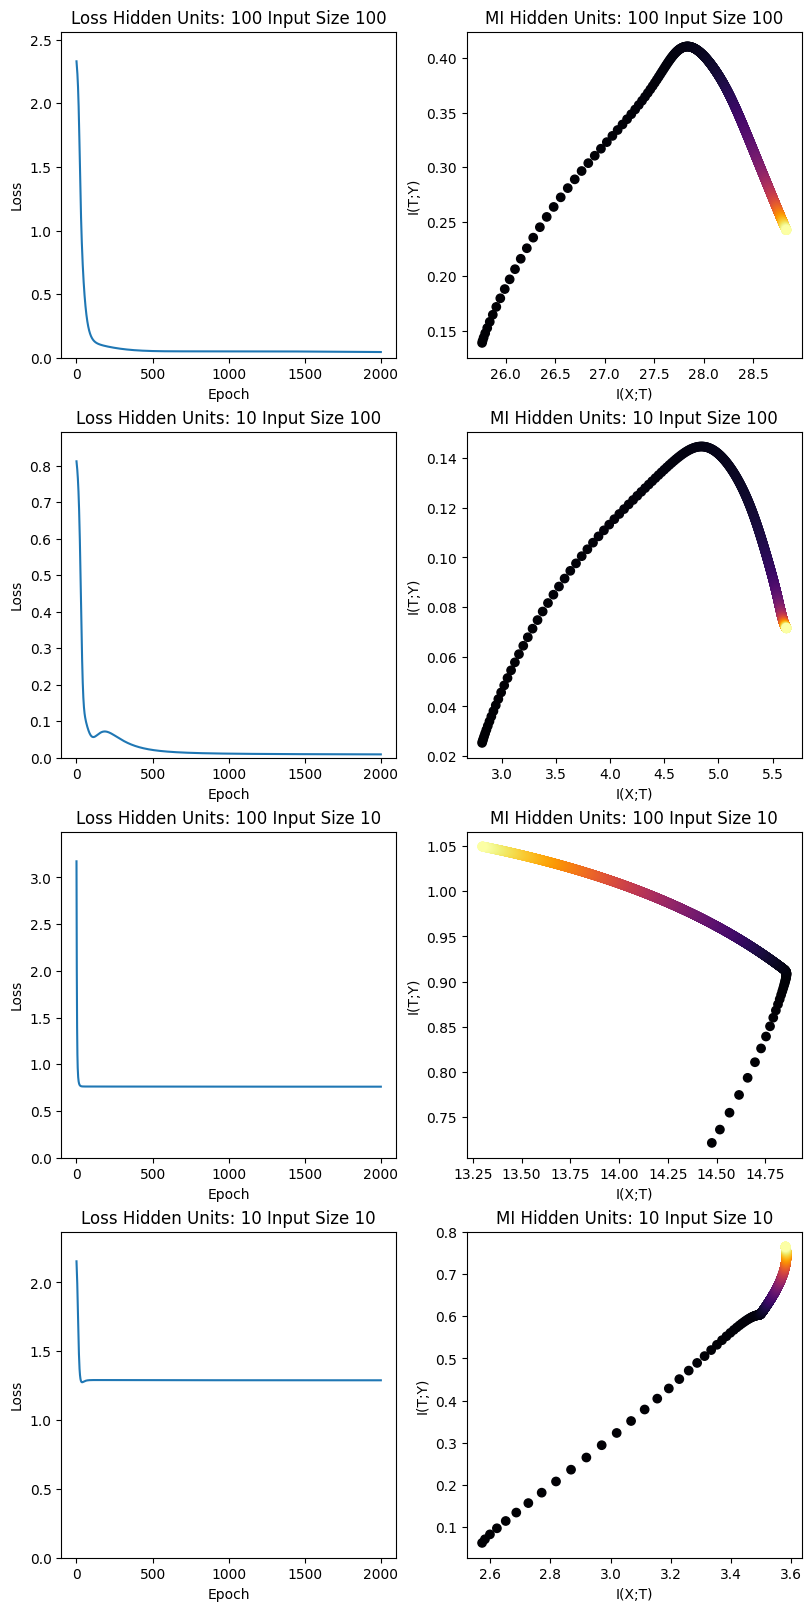

In [13]:
fig, axs = plt.subplots(4,2, figsize=(8,16),layout='constrained')

cm = plt.cm.get_cmap('inferno')

HIDDEN_UNITS=[100,10,100,10]
INPUT_SIZE=[100,100,10,10]

for k, row in enumerate(axs):
    ll,MI_XT_l,MI_TY_l,el=Mutual_Information(sigma_0=SIGMA_0,sigma_W=SIGMA_W,sigma_MI=SIGMA_MI,hidden_units=HIDDEN_UNITS[k],input_size=INPUT_SIZE[k],output_size=OUTPUT_SIZE,P=100,num_epochs=NUM_EPOCHS,batch_size=5,lr=0.01)
    row[0].plot(el,ll)
    row[0].set_xlabel('Epoch')
    row[0].set_ylabel('Loss')
    row[0].set_ylim(0,max(ll)*1.1)
    row[0].set_title('Loss Hidden Units: {} Input Size {}'.format(HIDDEN_UNITS[k],INPUT_SIZE[k]))
    row[1].scatter(MI_XT_l,MI_TY_l,c=el,cmap=cm)
    row[1].set_xlabel('I(X;T)')
    row[1].set_ylabel('I(T;Y)')
    row[1].set_title('MI Hidden Units: {} Input Size {}'.format(HIDDEN_UNITS[k],INPUT_SIZE[k]))

#plt.savefig('plots/MIplots.png')
